## 0. Import

In [1]:
import random
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [15, 10]

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler # pip install torchsampler

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 1-1. Hyperparameter Setting

In [4]:
CFG = {
    'NUM_WORKERS':4,
    'ANTIGEN_WINDOW':128,
    'ANTIGEN_MAX_LEN':128, # ANTIGEN_WINDOW와 ANTIGEN_MAX_LEN은 같아야합니다.
    'EPITOPE_MAX_LEN':64, # 256
    'EPOCHS':100,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':512,
    'NUM_LAYERS': 2,
    'THRESHOLD':0.5,
    'SEED':41
}

## 1-2. Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 2-1. Data Pre-processing

In [6]:
def get_preprocessing(data_type, new_df):
    alpha_map = {
                'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5,
                'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11,
                'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17,
                'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23,
                'Y':24, 'Z':25, '<PAD>':26,
            }

    epitope_list = []
    left_antigen_list = []
    right_antigen_list = []
    
    for epitope, antigen, s_p, e_p in tqdm(zip(new_df['epitope_seq'], new_df['antigen_seq'], new_df['start_position'], new_df['end_position'])):
        epitope_pad = [26 for _ in range(CFG['EPITOPE_MAX_LEN'])]
        left_antigen_pad = [26 for _ in range(CFG['ANTIGEN_MAX_LEN'])]
        right_antigen_pad = [26 for _ in range(CFG['ANTIGEN_MAX_LEN'])]
        
        epitope = [alpha_map[x] for x in epitope]
        
        # Left antigen : [start_position-WINDOW : start_position]
        # Right antigen : [end_position : end_position+WINDOW]

        start_position = s_p-CFG['ANTIGEN_WINDOW']-1
        end_position = e_p+CFG['ANTIGEN_WINDOW']
        if start_position < 0:
            start_position = 0
        if end_position > len(antigen):
            end_position = len(antigen)
        
        # left / right antigen sequence 추출
        left_antigen = antigen[int(start_position) : int(s_p)-1]
        left_antigen = [alpha_map[x] for x in left_antigen]
        
        right_antigen = antigen[int(e_p) : int(end_position)]
        right_antigen = [alpha_map[x] for x in right_antigen]

        if CFG['EPITOPE_MAX_LEN']<len(epitope):
            epitope_pad[:len(epitope)] = epitope[:CFG['EPITOPE_MAX_LEN']]
        else:
            epitope_pad[:len(epitope)] = epitope[:]

        left_antigen_pad[:len(left_antigen)] = left_antigen[:]
        right_antigen_pad[:len(right_antigen)] = right_antigen[:]
        
        epitope_list.append(epitope_pad)
        left_antigen_list.append(left_antigen_pad)
        right_antigen_list.append(right_antigen_pad)
    
    label_list = None
    if data_type != 'test':
        label_list = []
        for label in new_df['label']:
            label_list.append(label)
    print(f'{data_type} dataframe preprocessing was done.')
    return epitope_list, left_antigen_list, right_antigen_list, label_list

In [7]:
df = pd.read_csv('./data/train.csv') #, encoding='utf-8')
# Split Train : Validation = 0.8 : 0.2
train_len = len(df)
train_idx = np.arange(train_len)

# random split
np.random.shuffle(train_idx)

train_df = df.iloc[train_idx[:int(train_len*0.8)]]
val_df = df.iloc[int(train_len*0.8):]

In [8]:
train_epitope_list, train_left_antigen_list, train_right_antigen_list, train_label_list = get_preprocessing('train', train_df)
val_epitope_list, val_left_antigen_list, val_right_antigen_list, val_label_list = get_preprocessing('val', val_df)

152648it [00:06, 22747.41it/s]


train dataframe preprocessing was done.


38163it [00:01, 33155.88it/s]

val dataframe preprocessing was done.


## 2-2. CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, epitope_list, left_antigen_list, right_antigen_list, label_list):
        self.epitope_list = epitope_list
        self.left_antigen_list = left_antigen_list
        self.right_antigen_list = right_antigen_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        self.epitope = self.epitope_list[index]
        self.left_antigen = self.left_antigen_list[index]
        self.right_antigen = self.right_antigen_list[index]
        
        if self.label_list is not None:
            self.label = self.label_list[index]
            return torch.tensor(self.epitope), torch.tensor(self.left_antigen), torch.tensor(self.right_antigen), self.label
        else:
            return torch.tensor(self.epitope), torch.tensor(self.left_antigen), torch.tensor(self.right_antigen)
        
    def __len__(self):
        return len(self.epitope_list)
    
    def get_labels(self):
        return self.label_list

In [10]:
train_dataset = CustomDataset(train_epitope_list, train_left_antigen_list, train_right_antigen_list, train_label_list)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], num_workers=CFG['NUM_WORKERS'], sampler=ImbalancedDatasetSampler(train_dataset)) # shuffle=True, 

val_dataset = CustomDataset(val_epitope_list, val_left_antigen_list, val_right_antigen_list, val_label_list)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

## 3_option 1. LSTM Model Define

In [11]:
class BaseModel(nn.Module):
    def __init__(self,
                 epitope_length=CFG['EPITOPE_MAX_LEN'],
                 epitope_emb_node=10,
                 epitope_hidden_dim=64,
                 left_antigen_length=CFG['ANTIGEN_MAX_LEN'],
                 left_antigen_emb_node=10,
                 left_antigen_hidden_dim=64,
                 right_antigen_length=CFG['ANTIGEN_MAX_LEN'],
                 right_antigen_emb_node=10,
                 right_antigen_hidden_dim=64,
                 num_layers=CFG['NUM_LAYERS'],
                 num_class=2,
                 drop_prob=0.5,
                 lstm_bidirect=True
                ):
        super(BaseModel, self).__init__()
        self.num_class = num_class
        self.num_layers = num_layers
        self.epitope_hidden_dim = epitope_hidden_dim
        self.left_antigen_hidden_dim = left_antigen_hidden_dim
        self.right_antigen_hidden_dim = right_antigen_hidden_dim
        # Embedding Layer
        self.epitope_embed = nn.Embedding(num_embeddings=27, 
                                          embedding_dim=epitope_emb_node, 
                                          padding_idx=26
                                         )
        self.left_antigen_embed = nn.Embedding(num_embeddings=27,
                                          embedding_dim=left_antigen_emb_node, 
                                          padding_idx=26
                                         )
        self.right_antigen_embed = nn.Embedding(num_embeddings=27,
                                          embedding_dim=right_antigen_emb_node, 
                                          padding_idx=26
                                         )
        # LSTM
        self.epitope_lstm = nn.LSTM(input_size=epitope_emb_node, 
                                    hidden_size=epitope_hidden_dim, 
                                    batch_first=True, 
                                    bidirectional=lstm_bidirect,
                                    num_layers=num_layers,
                                    dropout=drop_prob
                                   )
        self.left_antigen_lstm = nn.LSTM(input_size=left_antigen_emb_node, 
                                    hidden_size=left_antigen_hidden_dim, 
                                    batch_first=True, 
                                    bidirectional=lstm_bidirect,
                                    num_layers=num_layers,
                                    dropout=drop_prob
                                   )
        self.right_antigen_lstm = nn.LSTM(input_size=right_antigen_emb_node, 
                                    hidden_size=right_antigen_hidden_dim, 
                                    batch_first=True, 
                                    bidirectional=lstm_bidirect,
                                    num_layers=num_layers,
                                    dropout=drop_prob
                                   )

        # Classifier
        in_channels = epitope_hidden_dim+left_antigen_hidden_dim+right_antigen_hidden_dim
        if lstm_bidirect:
            in_channels *= 2
            
        self.classifier = nn.Sequential(
            nn.LeakyReLU(True),
            nn.BatchNorm1d(in_channels),
            nn.Linear(in_channels, in_channels//4),
            nn.LeakyReLU(True),
            nn.BatchNorm1d(in_channels//4),
            nn.Linear(in_channels//4, self.num_class)
        )
        
        # Weight Initialization 
        self.init_weights()
        
    def forward(self, epitope_x, left_antigen_x, right_antigen_x):
        BATCH_SIZE = epitope_x.size(0)
        
#         # Initialize hidden cell
#         hc       = self.init_hidden_cell(self.epitope_lstm, BATCH_SIZE, self.epitope_hidden_dim)
#         left_hc  = self.init_hidden_cell(self.left_antigen_lstm, BATCH_SIZE, self.left_antigen_hidden_dim)
#         right_hc = self.init_hidden_cell(self.right_antigen_lstm, BATCH_SIZE, self.right_antigen_hidden_dim)
        
        # Get Embedding Vector
        epitope_x       = self.epitope_embed(epitope_x)
        left_antigen_x  = self.left_antigen_embed(left_antigen_x)
        right_antigen_x = self.right_antigen_embed(right_antigen_x)
        
        # LSTM
        epitope_hidden, _ = self.epitope_lstm(epitope_x) #, hc)
        epitope_hidden = epitope_hidden[:,-1,:]

        left_antigen_hidden, _ = self.left_antigen_lstm(left_antigen_x) #, left_hc)
        left_antigen_hidden = left_antigen_hidden[:,-1,:]
        
        right_antigen_hidden, _ = self.right_antigen_lstm(right_antigen_x) #, right_hc)
        right_antigen_hidden = right_antigen_hidden[:,-1,:]
        
        # Feature Concat -> Binary Classifier
        x = torch.cat([epitope_hidden, left_antigen_hidden, right_antigen_hidden], axis=-1)
        x = torch.cat([left_antigen_hidden, right_antigen_hidden], axis=-1)
        x = epitope_hidden
        
        x = self.classifier(x).view(-1, self.num_class)
        return x
    
    
    def init_weights(self):
        # Classifier
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.01)
        # LSTM
        lstms = [self.epitope_lstm, self.left_antigen_embed, self.right_antigen_embed]
        for lstm in lstms:
            for name, param in lstm.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.)
                elif 'weight' in name:
                    nn.init.xavier_uniform_(param)

    def init_hidden_cell(self, lstm, batch_size, hidden_dim):
        weight = next(lstm.parameters()).data
        return (weight.new(self.num_layers, batch_size, hidden_dim).zero_(),
                weight.new(self.num_layers, batch_size, hidden_dim).zero_())

## 3_option 2. CNN Model Define

In [19]:
class CNNModel(nn.Module):
    def __init__(self,
                 epitope_length=CFG['EPITOPE_MAX_LEN'],
                 epitope_emb_node=10,
                 epitope_hidden_dim=64,
                 left_antigen_length=CFG['ANTIGEN_MAX_LEN'],
                 left_antigen_emb_node=10,
                 left_antigen_hidden_dim=64,
                 right_antigen_length=CFG['ANTIGEN_MAX_LEN'],
                 right_antigen_emb_node=10,
                 right_antigen_hidden_dim=64,
                 num_class=2,
                 drop_prob=0.5
                ):
        super(CNNModel, self).__init__()
        self.num_class = num_class
        self.epitope_hidden_dim = epitope_hidden_dim
        
        # Embedding Layer
        self.epitope_embed = nn.Embedding(num_embeddings=27, 
                                          embedding_dim=epitope_emb_node, 
                                          padding_idx=26
                                         )
        self.left_antigen_embed = nn.Embedding(num_embeddings=27,
                                          embedding_dim=left_antigen_emb_node, 
                                          padding_idx=26
                                         )
        self.right_antigen_embed = nn.Embedding(num_embeddings=27,
                                          embedding_dim=right_antigen_emb_node, 
                                          padding_idx=26
                                         )
        
        # CNN
        self.epitope_cnn1 = nn.Conv1d(in_channels=epitope_emb_node, out_channels=epitope_emb_node*2, kernel_size=3, padding=1, stride=2)
        self.epitope_cnn2 = nn.Conv1d(in_channels=epitope_emb_node*2, out_channels=epitope_emb_node*4, kernel_size=3, padding=1, stride=2)
        self.epitope_cnn3 = nn.Conv1d(in_channels=epitope_emb_node*4, out_channels=epitope_emb_node, kernel_size=3, padding=1, stride=2)
        
        # BatchNorm
        
        self.relu = nn.ReLU(inplace=True)
        
        # Classifier
        self.in_channels = epitope_emb_node * (epitope_length // (2 ** 3))
            
        self.classifier = nn.Sequential(
            nn.LeakyReLU(True),
            nn.BatchNorm1d(self.in_channels),
            nn.Linear(self.in_channels, self.in_channels//4),
            nn.LeakyReLU(True),
            nn.BatchNorm1d(self.in_channels//4),
            nn.Linear(self.in_channels//4, self.num_class)
        )
        
        # Weight Initialization 
        self.init_weights()
        
    def forward(self, epitope_x, left_antigen_x, right_antigen_x):
        BATCH_SIZE = epitope_x.size(0)
        
        # Get Embedding Vector
        epitope_x       = self.epitope_embed(epitope_x)

        # CNN
        epitope_x = epitope_x.permute(0,2,1)
        epitope_hidden = self.relu(self.epitope_cnn1(epitope_x))
        epitope_hidden = self.relu(self.epitope_cnn2(epitope_hidden))
        epitope_hidden = self.relu(self.epitope_cnn3(epitope_hidden))
        
        # Feature Concat -> Binary Classifier
        x = epitope_hidden.reshape(epitope_hidden.size(0), -1)
        
        x = self.classifier(x).view(-1, self.num_class)
        return x
    
    
    def init_weights(self):
        # Classifier
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight)
                layer.bias.data.fill_(0.01)
        # CNN
        cnns = [self.epitope_cnn1, self.epitope_cnn2, self.epitope_cnn3]
        for lstm in cnns:
            for name, param in lstm.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.)
                elif 'weight' in name:
                    nn.init.xavier_uniform_(param)

## Train

In [20]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    #criterion = nn.BCEWithLogitsLoss().to(device) 
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_val_f1 = 0
    best_epoch = 0
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for epitope_seq, left_antigen_seq, right_antigen_seq, label in tqdm(iter(train_loader)):
            epitope_seq = epitope_seq.to(device)
            left_antigen_seq = left_antigen_seq.to(device)
            right_antigen_seq = right_antigen_seq.to(device)
            label = label.long().to(device)
            
            optimizer.zero_grad()
            
            output = model(epitope_seq, left_antigen_seq, right_antigen_seq)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            if scheduler is not None:
                scheduler.step()
                    
        val_loss, val_f1, val_acc, val_precision, val_recall, val_conf = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val F1 : [{val_f1:.5f}] Val ACC : [{val_acc:.5f}] ')
        print(f'                                   Val Precision : [{val_precision:.5f}] Val Recall : [{val_recall:.5f}]')
        print(val_conf)
        
        if best_val_f1 < val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
            print('Model Saved.')
    return best_val_f1, best_epoch

In [21]:
def validation(model, val_loader, criterion, device, th=CFG['THRESHOLD']):
    model.eval()
    pred_proba_label = []
    true_label = []
    val_loss = []
    with torch.no_grad():
        for epitope_seq, left_antigen_seq, right_antigen_seq, label in tqdm(iter(val_loader)):
            epitope_seq = epitope_seq.to(device)
            left_antigen_seq = left_antigen_seq.to(device)
            right_antigen_seq = right_antigen_seq.to(device)
            label = label.long().to(device)
            
            model_pred = model(epitope_seq, left_antigen_seq, right_antigen_seq)
            loss = criterion(model_pred, label)
            model_pred = torch.softmax(model_pred, dim=1)[:,1].to('cpu')
            pred_proba_label += model_pred.tolist()
            true_label += label.to('cpu').tolist()
            
            val_loss.append(loss.item())
            
    pred_label = np.where(np.array(pred_proba_label)>th, 1, 0)
    val_f1        = f1_score(true_label, pred_label, average='macro')
    val_confusion = confusion_matrix(true_label, pred_label)
    val_acc       = accuracy_score(true_label, pred_label)
    val_precision = precision_score(true_label, pred_label)
    val_recall    = recall_score(true_label, pred_label)
    return np.mean(val_loss), val_f1, val_acc, val_precision, val_recall, val_confusion

In [22]:
#model = BaseModel()
model = CNNModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*CFG['EPOCHS'], eta_min=0)

best_score, best_epoch = train(model, optimizer, train_loader, val_loader, scheduler, device)
print(f'Best Validation F1 Score : [{best_score:.5f}] at {best_epoch} EPOCH')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c27a267a0>
Traceback (most recent call last):
  File "/home/suhyun/.conda/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/suhyun/.conda/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/suhyun/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  0%|          | 0/299 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c27a267a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c27a267a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c27a267a0>

Traceback (most recent call last):
  Fil

Epoch : [1] Train Loss : [0.59884] Val Loss : [0.41804] Val F1 : [0.62205] Val ACC : [0.85997] 
                                   Val Precision : [0.49206] Val Recall : [0.23949]
[[31549  1311]
 [ 4033  1270]]
Model Saved.



100%|██████████| 75/75 [00:01<00:00, 74.53it/s]


Epoch : [2] Train Loss : [0.55280] Val Loss : [0.53823] Val F1 : [0.62038] Val ACC : [0.76700] 
                                   Val Precision : [0.30373] Val Recall : [0.52367]
[[26494  6366]
 [ 2526  2777]]


100%|██████████| 75/75 [00:01<00:00, 72.68it/s]


Epoch : [3] Train Loss : [0.52898] Val Loss : [0.52560] Val F1 : [0.63325] Val ACC : [0.77997] 
                                   Val Precision : [0.32263] Val Recall : [0.53064]
[[26952  5908]
 [ 2489  2814]]
Model Saved.


100%|██████████| 75/75 [00:01<00:00, 73.76it/s]


Epoch : [4] Train Loss : [0.51141] Val Loss : [0.54561] Val F1 : [0.62659] Val ACC : [0.75353] 
                                   Val Precision : [0.30663] Val Recall : [0.61343]
[[25504  7356]
 [ 2050  3253]]


100%|██████████| 75/75 [00:01<00:00, 74.87it/s]


Epoch : [5] Train Loss : [0.49721] Val Loss : [1.90007] Val F1 : [0.16783] Val ACC : [0.17585] 
                                   Val Precision : [0.14284] Val Recall : [0.98605]
[[ 1482 31378]
 [   74  5229]]


100%|██████████| 75/75 [00:01<00:00, 67.05it/s]


Epoch : [6] Train Loss : [0.48673] Val Loss : [0.43636] Val F1 : [0.66783] Val ACC : [0.82064] 
                                   Val Precision : [0.38948] Val Recall : [0.51235]
[[28601  4259]
 [ 2586  2717]]
Model Saved.


100%|██████████| 75/75 [00:01<00:00, 71.94it/s]


Epoch : [7] Train Loss : [0.47340] Val Loss : [1.74365] Val F1 : [0.18547] Val ACC : [0.19084] 
                                   Val Precision : [0.14436] Val Recall : [0.97888]
[[ 2092 30768]
 [  112  5191]]


100%|██████████| 75/75 [00:00<00:00, 77.09it/s]


Epoch : [8] Train Loss : [0.46506] Val Loss : [0.36086] Val F1 : [0.64647] Val ACC : [0.86906] 
                                   Val Precision : [0.55935] Val Recall : [0.27192]
[[31724  1136]
 [ 3861  1442]]


100%|██████████| 75/75 [00:01<00:00, 74.80it/s]


Epoch : [9] Train Loss : [0.46341] Val Loss : [1.42104] Val F1 : [0.27655] Val ACC : [0.27658] 
                                   Val Precision : [0.15833] Val Recall : [0.97454]
[[ 5387 27473]
 [  135  5168]]


100%|██████████| 75/75 [00:01<00:00, 69.41it/s]

Epoch : [10] Train Loss : [0.45290] Val Loss : [0.53109] Val F1 : [0.63992] Val ACC : [0.75796] 
                                   Val Precision : [0.32134] Val Recall : [0.66717]
[[25388  7472]
 [ 1765  3538]]



100%|██████████| 75/75 [00:01<00:00, 70.07it/s]

Epoch : [11] Train Loss : [0.45075] Val Loss : [0.44589] Val F1 : [0.66656] Val ACC : [0.81016] 
                                   Val Precision : [0.37577] Val Recall : [0.55384]
[[27981  4879]
 [ 2366  2937]]



100%|██████████| 75/75 [00:00<00:00, 76.47it/s]


Epoch : [12] Train Loss : [0.44428] Val Loss : [1.29435] Val F1 : [0.31989] Val ACC : [0.32196] 
                                   Val Precision : [0.16551] Val Recall : [0.95983]
[[ 7197 25663]
 [  213  5090]]


100%|██████████| 75/75 [00:01<00:00, 69.69it/s]


Epoch : [13] Train Loss : [0.44058] Val Loss : [0.40512] Val F1 : [0.68143] Val ACC : [0.83649] 
                                   Val Precision : [0.42486] Val Recall : [0.49953]
[[29274  3586]
 [ 2654  2649]]
Model Saved.


100%|██████████| 75/75 [00:00<00:00, 77.67it/s]


Epoch : [14] Train Loss : [0.43797] Val Loss : [0.50340] Val F1 : [0.65371] Val ACC : [0.77465] 
                                   Val Precision : [0.34006] Val Recall : [0.66095]
[[26058  6802]
 [ 1798  3505]]


100%|██████████| 75/75 [00:01<00:00, 74.84it/s]


Epoch : [15] Train Loss : [0.43411] Val Loss : [0.66363] Val F1 : [0.58038] Val ACC : [0.66578] 
                                   Val Precision : [0.26183] Val Recall : [0.77239]
[[21312 11548]
 [ 1207  4096]]


100%|██████████| 75/75 [00:00<00:00, 75.93it/s]


Epoch : [16] Train Loss : [0.43079] Val Loss : [1.35716] Val F1 : [0.31024] Val ACC : [0.31156] 
                                   Val Precision : [0.16383] Val Recall : [0.96361]
[[ 6780 26080]
 [  193  5110]]


100%|██████████| 75/75 [00:01<00:00, 70.04it/s]


Epoch : [17] Train Loss : [0.42994] Val Loss : [0.75899] Val F1 : [0.53309] Val ACC : [0.59628] 
                                   Val Precision : [0.23156] Val Recall : [0.82180]
[[18398 14462]
 [  945  4358]]


100%|██████████| 75/75 [00:01<00:00, 72.41it/s]


Epoch : [18] Train Loss : [0.42831] Val Loss : [0.71599] Val F1 : [0.55680] Val ACC : [0.62846] 
                                   Val Precision : [0.24660] Val Recall : [0.81444]
[[19665 13195]
 [  984  4319]]


100%|██████████| 75/75 [00:00<00:00, 77.11it/s]


Epoch : [19] Train Loss : [0.42342] Val Loss : [0.92494] Val F1 : [0.47357] Val ACC : [0.50981] 
                                   Val Precision : [0.20664] Val Recall : [0.89025]
[[14735 18125]
 [  582  4721]]


100%|██████████| 75/75 [00:01<00:00, 68.27it/s]

Epoch : [20] Train Loss : [0.42408] Val Loss : [0.94921] Val F1 : [0.46090] Val ACC : [0.49165] 
                                   Val Precision : [0.20316] Val Recall : [0.90967]
[[13939 18921]
 [  479  4824]]



100%|██████████| 75/75 [00:00<00:00, 75.60it/s]


Epoch : [21] Train Loss : [0.41727] Val Loss : [0.78164] Val F1 : [0.52354] Val ACC : [0.57799] 
                                   Val Precision : [0.22938] Val Recall : [0.86328]
[[17480 15380]
 [  725  4578]]


100%|██████████| 75/75 [00:01<00:00, 73.39it/s]


Epoch : [22] Train Loss : [0.41610] Val Loss : [0.95950] Val F1 : [0.45428] Val ACC : [0.48361] 
                                   Val Precision : [0.20007] Val Recall : [0.90590]
[[13652 19208]
 [  499  4804]]


100%|██████████| 75/75 [00:00<00:00, 77.87it/s]


Epoch : [23] Train Loss : [0.41530] Val Loss : [0.79223] Val F1 : [0.52251] Val ACC : [0.57844] 
                                   Val Precision : [0.22764] Val Recall : [0.84990]
[[17568 15292]
 [  796  4507]]


100%|██████████| 75/75 [00:01<00:00, 74.20it/s]


Epoch : [24] Train Loss : [0.41398] Val Loss : [0.44740] Val F1 : [0.67249] Val ACC : [0.80769] 
                                   Val Precision : [0.37794] Val Recall : [0.59438]
[[27672  5188]
 [ 2151  3152]]


100%|██████████| 75/75 [00:01<00:00, 74.36it/s]


Epoch : [25] Train Loss : [0.41113] Val Loss : [0.54115] Val F1 : [0.63562] Val ACC : [0.74711] 
                                   Val Precision : [0.31498] Val Recall : [0.69791]
[[24811  8049]
 [ 1602  3701]]


100%|██████████| 75/75 [00:00<00:00, 81.65it/s]

Epoch : [26] Train Loss : [0.41184] Val Loss : [0.85692] Val F1 : [0.50103] Val ACC : [0.54731] 
                                   Val Precision : [0.21811] Val Recall : [0.87347]
[[16255 16605]
 [  671  4632]]



100%|██████████| 75/75 [00:01<00:00, 74.72it/s]


Epoch : [27] Train Loss : [0.40963] Val Loss : [0.64205] Val F1 : [0.60176] Val ACC : [0.68939] 
                                   Val Precision : [0.28103] Val Recall : [0.79276]
[[22105 10755]
 [ 1099  4204]]


100%|██████████| 75/75 [00:00<00:00, 77.05it/s]


Epoch : [28] Train Loss : [0.40650] Val Loss : [0.41319] Val F1 : [0.68451] Val ACC : [0.82397] 
                                   Val Precision : [0.40550] Val Recall : [0.57251]
[[28409  4451]
 [ 2267  3036]]
Model Saved.


100%|██████████| 75/75 [00:01<00:00, 69.82it/s]


Epoch : [29] Train Loss : [0.40430] Val Loss : [0.42908] Val F1 : [0.68132] Val ACC : [0.81647] 
                                   Val Precision : [0.39378] Val Recall : [0.59457]
[[28006  4854]
 [ 2150  3153]]


100%|██████████| 75/75 [00:00<00:00, 75.65it/s]


Epoch : [30] Train Loss : [0.40679] Val Loss : [0.92210] Val F1 : [0.47696] Val ACC : [0.51348] 
                                   Val Precision : [0.20882] Val Recall : [0.89685]
[[14840 18020]
 [  547  4756]]


100%|██████████| 75/75 [00:00<00:00, 78.68it/s]


Epoch : [31] Train Loss : [0.40355] Val Loss : [0.51623] Val F1 : [0.64937] Val ACC : [0.76386] 
                                   Val Precision : [0.33222] Val Recall : [0.69244]
[[25479  7381]
 [ 1631  3672]]


100%|██████████| 75/75 [00:01<00:00, 69.97it/s]


Epoch : [32] Train Loss : [0.40175] Val Loss : [0.76888] Val F1 : [0.54307] Val ACC : [0.60375] 
                                   Val Precision : [0.24096] Val Recall : [0.86121]
[[18474 14386]
 [  736  4567]]


100%|██████████| 75/75 [00:01<00:00, 69.70it/s]


Epoch : [33] Train Loss : [0.39966] Val Loss : [0.54034] Val F1 : [0.63896] Val ACC : [0.74968] 
                                   Val Precision : [0.31878] Val Recall : [0.70488]
[[24872  7988]
 [ 1565  3738]]


100%|██████████| 75/75 [00:01<00:00, 72.12it/s]


Epoch : [34] Train Loss : [0.39764] Val Loss : [0.44198] Val F1 : [0.67635] Val ACC : [0.80982] 
                                   Val Precision : [0.38298] Val Recall : [0.60324]
[[27706  5154]
 [ 2104  3199]]


100%|██████████| 75/75 [00:01<00:00, 72.56it/s]


Epoch : [35] Train Loss : [0.39928] Val Loss : [0.56235] Val F1 : [0.63163] Val ACC : [0.73333] 
                                   Val Precision : [0.30973] Val Recall : [0.74807]
[[24019  8841]
 [ 1336  3967]]


100%|██████████| 75/75 [00:01<00:00, 68.04it/s]


Epoch : [36] Train Loss : [0.39718] Val Loss : [0.60364] Val F1 : [0.61200] Val ACC : [0.70450] 
                                   Val Precision : [0.29003] Val Recall : [0.77805]
[[22760 10100]
 [ 1177  4126]]


100%|██████████| 75/75 [00:01<00:00, 74.12it/s]


Epoch : [37] Train Loss : [0.39584] Val Loss : [0.96231] Val F1 : [0.46843] Val ACC : [0.49999] 
                                   Val Precision : [0.20759] Val Recall : [0.92231]
[[14190 18670]
 [  412  4891]]


100%|██████████| 75/75 [00:01<00:00, 74.96it/s]


Epoch : [38] Train Loss : [0.39748] Val Loss : [0.57878] Val F1 : [0.62559] Val ACC : [0.72675] 
                                   Val Precision : [0.30323] Val Recall : [0.74467]
[[23786  9074]
 [ 1354  3949]]


100%|██████████| 75/75 [00:02<00:00, 34.89it/s]

Epoch : [39] Train Loss : [0.39536] Val Loss : [0.54818] Val F1 : [0.63638] Val ACC : [0.74087] 
                                   Val Precision : [0.31511] Val Recall : [0.73694]
[[24366  8494]
 [ 1395  3908]]



100%|██████████| 75/75 [00:00<00:00, 75.49it/s]

Epoch : [40] Train Loss : [0.39392] Val Loss : [0.60202] Val F1 : [0.60923] Val ACC : [0.70359] 
                                   Val Precision : [0.28702] Val Recall : [0.76353]
[[22802 10058]
 [ 1254  4049]]



100%|██████████| 75/75 [00:00<00:00, 76.78it/s]


Epoch : [41] Train Loss : [0.39050] Val Loss : [0.69324] Val F1 : [0.58000] Val ACC : [0.65590] 
                                   Val Precision : [0.26471] Val Recall : [0.83047]
[[20627 12233]
 [  899  4404]]


100%|██████████| 75/75 [00:01<00:00, 73.93it/s]


Epoch : [42] Train Loss : [0.38986] Val Loss : [0.38307] Val F1 : [0.68750] Val ACC : [0.84372] 
                                   Val Precision : [0.44376] Val Recall : [0.49180]
[[29591  3269]
 [ 2695  2608]]
Model Saved.


100%|██████████| 75/75 [00:01<00:00, 73.00it/s]


Epoch : [43] Train Loss : [0.39080] Val Loss : [0.65502] Val F1 : [0.59389] Val ACC : [0.67751] 
                                   Val Precision : [0.27468] Val Recall : [0.80502]
[[21587 11273]
 [ 1034  4269]]


100%|██████████| 75/75 [00:01<00:00, 68.11it/s]


Epoch : [44] Train Loss : [0.39131] Val Loss : [0.45411] Val F1 : [0.67246] Val ACC : [0.80099] 
                                   Val Precision : [0.37201] Val Recall : [0.62814]
[[27237  5623]
 [ 1972  3331]]


100%|██████████| 75/75 [00:01<00:00, 71.79it/s]

Epoch : [45] Train Loss : [0.38993] Val Loss : [0.72301] Val F1 : [0.56718] Val ACC : [0.63714] 
                                   Val Precision : [0.25609] Val Recall : [0.84594]
[[19829 13031]
 [  817  4486]]



100%|██████████| 75/75 [00:00<00:00, 76.76it/s]


Epoch : [46] Train Loss : [0.38655] Val Loss : [0.54842] Val F1 : [0.64023] Val ACC : [0.74635] 
                                   Val Precision : [0.31962] Val Recall : [0.73128]
[[24605  8255]
 [ 1425  3878]]


100%|██████████| 75/75 [00:01<00:00, 67.79it/s]

Epoch : [47] Train Loss : [0.39066] Val Loss : [0.45688] Val F1 : [0.67524] Val ACC : [0.79868] 
                                   Val Precision : [0.37248] Val Recall : [0.65548]
[[27004  5856]
 [ 1827  3476]]



100%|██████████| 75/75 [00:00<00:00, 79.27it/s]


Epoch : [48] Train Loss : [0.38806] Val Loss : [0.86729] Val F1 : [0.51578] Val ACC : [0.56314] 
                                   Val Precision : [0.22834] Val Recall : [0.90100]
[[16713 16147]
 [  525  4778]]


100%|██████████| 75/75 [00:01<00:00, 74.81it/s]


Epoch : [49] Train Loss : [0.38809] Val Loss : [0.50633] Val F1 : [0.65443] Val ACC : [0.76747] 
                                   Val Precision : [0.33817] Val Recall : [0.70356]
[[25558  7302]
 [ 1572  3731]]


100%|██████████| 75/75 [00:01<00:00, 73.33it/s]


Epoch : [50] Train Loss : [0.38718] Val Loss : [0.76670] Val F1 : [0.55245] Val ACC : [0.61410] 
                                   Val Precision : [0.24797] Val Recall : [0.87422]
[[18800 14060]
 [  667  4636]]


100%|██████████| 75/75 [00:00<00:00, 75.77it/s]


Epoch : [51] Train Loss : [0.38720] Val Loss : [0.63107] Val F1 : [0.60700] Val ACC : [0.69473] 
                                   Val Precision : [0.28599] Val Recall : [0.79974]
[[22272 10588]
 [ 1062  4241]]


100%|██████████| 75/75 [00:01<00:00, 73.59it/s]

Epoch : [52] Train Loss : [0.38605] Val Loss : [0.52273] Val F1 : [0.64977] Val ACC : [0.75896] 
                                   Val Precision : [0.33137] Val Recall : [0.72186]
[[25136  7724]
 [ 1475  3828]]



100%|██████████| 75/75 [00:01<00:00, 73.33it/s]


Epoch : [53] Train Loss : [0.38388] Val Loss : [0.76480] Val F1 : [0.55430] Val ACC : [0.61701] 
                                   Val Precision : [0.24891] Val Recall : [0.87045]
[[18931 13929]
 [  687  4616]]


100%|██████████| 75/75 [00:00<00:00, 77.00it/s]


Epoch : [54] Train Loss : [0.38289] Val Loss : [0.51025] Val F1 : [0.65396] Val ACC : [0.76606] 
                                   Val Precision : [0.33728] Val Recall : [0.70847]
[[25478  7382]
 [ 1546  3757]]


100%|██████████| 75/75 [00:01<00:00, 67.75it/s]


Epoch : [55] Train Loss : [0.38161] Val Loss : [0.61893] Val F1 : [0.61188] Val ACC : [0.69981] 
                                   Val Precision : [0.29064] Val Recall : [0.80539]
[[22436 10424]
 [ 1032  4271]]


100%|██████████| 75/75 [00:00<00:00, 75.58it/s]


Epoch : [56] Train Loss : [0.38125] Val Loss : [0.47267] Val F1 : [0.66962] Val ACC : [0.79084] 
                                   Val Precision : [0.36252] Val Recall : [0.66604]
[[26649  6211]
 [ 1771  3532]]


100%|██████████| 75/75 [00:01<00:00, 69.24it/s]


Epoch : [57] Train Loss : [0.38016] Val Loss : [0.49804] Val F1 : [0.65792] Val ACC : [0.77305] 
                                   Val Precision : [0.34338] Val Recall : [0.69414]
[[25821  7039]
 [ 1622  3681]]


100%|██████████| 75/75 [00:01<00:00, 73.53it/s]


Epoch : [58] Train Loss : [0.38060] Val Loss : [0.44647] Val F1 : [0.67936] Val ACC : [0.80827] 
                                   Val Precision : [0.38375] Val Recall : [0.62682]
[[27522  5338]
 [ 1979  3324]]


100%|██████████| 75/75 [00:00<00:00, 75.15it/s]


Epoch : [59] Train Loss : [0.38038] Val Loss : [0.59964] Val F1 : [0.62227] Val ACC : [0.71603] 
                                   Val Precision : [0.30016] Val Recall : [0.78371]
[[23170  9690]
 [ 1147  4156]]


100%|██████████| 75/75 [00:01<00:00, 71.39it/s]


Epoch : [60] Train Loss : [0.38030] Val Loss : [0.51695] Val F1 : [0.65433] Val ACC : [0.76522] 
                                   Val Precision : [0.33739] Val Recall : [0.71544]
[[25409  7451]
 [ 1509  3794]]


100%|██████████| 75/75 [00:01<00:00, 73.31it/s]


Epoch : [61] Train Loss : [0.37871] Val Loss : [0.63420] Val F1 : [0.60628] Val ACC : [0.69169] 
                                   Val Precision : [0.28578] Val Recall : [0.81294]
[[22086 10774]
 [  992  4311]]


100%|██████████| 75/75 [00:00<00:00, 77.24it/s]


Epoch : [62] Train Loss : [0.38042] Val Loss : [0.55238] Val F1 : [0.64192] Val ACC : [0.74405] 
                                   Val Precision : [0.32110] Val Recall : [0.75561]
[[24388  8472]
 [ 1296  4007]]


100%|██████████| 75/75 [00:02<00:00, 25.48it/s]


Epoch : [63] Train Loss : [0.37874] Val Loss : [0.59798] Val F1 : [0.62468] Val ACC : [0.71737] 
                                   Val Precision : [0.30270] Val Recall : [0.79314]
[[23171  9689]
 [ 1097  4206]]


100%|██████████| 75/75 [00:00<00:00, 79.10it/s]


Epoch : [64] Train Loss : [0.37670] Val Loss : [0.71555] Val F1 : [0.57623] Val ACC : [0.64772] 
                                   Val Precision : [0.26314] Val Recall : [0.85272]
[[20197 12663]
 [  781  4522]]


100%|██████████| 75/75 [00:01<00:00, 71.86it/s]


Epoch : [65] Train Loss : [0.37742] Val Loss : [0.60544] Val F1 : [0.61755] Val ACC : [0.70985] 
                                   Val Precision : [0.29556] Val Recall : [0.78654]
[[22919  9941]
 [ 1132  4171]]


100%|██████████| 75/75 [00:01<00:00, 71.85it/s]


Epoch : [66] Train Loss : [0.37652] Val Loss : [0.59355] Val F1 : [0.62496] Val ACC : [0.72141] 
                                   Val Precision : [0.30273] Val Recall : [0.77107]
[[23442  9418]
 [ 1214  4089]]


100%|██████████| 75/75 [00:01<00:00, 70.82it/s]

Epoch : [67] Train Loss : [0.37466] Val Loss : [0.58225] Val F1 : [0.62966] Val ACC : [0.72906] 
                                   Val Precision : [0.30759] Val Recall : [0.75919]
[[23797  9063]
 [ 1277  4026]]



100%|██████████| 75/75 [00:01<00:00, 74.00it/s]


Epoch : [68] Train Loss : [0.37425] Val Loss : [0.71982] Val F1 : [0.57777] Val ACC : [0.64893] 
                                   Val Precision : [0.26458] Val Recall : [0.85782]
[[20216 12644]
 [  754  4549]]


100%|██████████| 75/75 [00:00<00:00, 77.62it/s]


Epoch : [69] Train Loss : [0.37574] Val Loss : [0.66423] Val F1 : [0.59634] Val ACC : [0.67728] 
                                   Val Precision : [0.27766] Val Recall : [0.82576]
[[21468 11392]
 [  924  4379]]


100%|██████████| 75/75 [00:00<00:00, 76.41it/s]


Epoch : [70] Train Loss : [0.37411] Val Loss : [0.63312] Val F1 : [0.60641] Val ACC : [0.69431] 
                                   Val Precision : [0.28540] Val Recall : [0.79785]
[[22266 10594]
 [ 1072  4231]]


100%|██████████| 75/75 [00:00<00:00, 82.14it/s] 


Epoch : [71] Train Loss : [0.37490] Val Loss : [0.59507] Val F1 : [0.62500] Val ACC : [0.71863] 
                                   Val Precision : [0.30295] Val Recall : [0.78786]
[[23247  9613]
 [ 1125  4178]]


100%|██████████| 75/75 [00:01<00:00, 74.20it/s]


Epoch : [72] Train Loss : [0.37481] Val Loss : [0.63839] Val F1 : [0.60558] Val ACC : [0.69140] 
                                   Val Precision : [0.28503] Val Recall : [0.80935]
[[22094 10766]
 [ 1011  4292]]


100%|██████████| 75/75 [00:01<00:00, 69.66it/s]

Epoch : [73] Train Loss : [0.37317] Val Loss : [0.60031] Val F1 : [0.62457] Val ACC : [0.71661] 
                                   Val Precision : [0.30264] Val Recall : [0.79691]
[[23122  9738]
 [ 1077  4226]]



100%|██████████| 75/75 [00:01<00:00, 73.51it/s]


Epoch : [74] Train Loss : [0.37382] Val Loss : [0.66034] Val F1 : [0.60024] Val ACC : [0.68257] 
                                   Val Precision : [0.28087] Val Recall : [0.82312]
[[21684 11176]
 [  938  4365]]


100%|██████████| 75/75 [00:00<00:00, 75.47it/s]


Epoch : [75] Train Loss : [0.37089] Val Loss : [0.64137] Val F1 : [0.60859] Val ACC : [0.69476] 
                                   Val Precision : [0.28782] Val Recall : [0.81162]
[[22210 10650]
 [  999  4304]]


100%|██████████| 75/75 [00:01<00:00, 74.59it/s]


Epoch : [76] Train Loss : [0.37466] Val Loss : [0.59102] Val F1 : [0.62663] Val ACC : [0.72156] 
                                   Val Precision : [0.30455] Val Recall : [0.78201]
[[23390  9470]
 [ 1156  4147]]


100%|██████████| 75/75 [00:01<00:00, 69.99it/s]

Epoch : [77] Train Loss : [0.37297] Val Loss : [0.65775] Val F1 : [0.60096] Val ACC : [0.68430] 
                                   Val Precision : [0.28128] Val Recall : [0.81784]
[[21778 11082]
 [  966  4337]]



100%|██████████| 75/75 [00:01<00:00, 70.30it/s]

Epoch : [78] Train Loss : [0.36989] Val Loss : [0.56199] Val F1 : [0.64082] Val ACC : [0.74158] 
                                   Val Precision : [0.31976] Val Recall : [0.76259]
[[24257  8603]
 [ 1259  4044]]



100%|██████████| 75/75 [00:00<00:00, 78.43it/s]


Epoch : [79] Train Loss : [0.37265] Val Loss : [0.63757] Val F1 : [0.61100] Val ACC : [0.69767] 
                                   Val Precision : [0.29002] Val Recall : [0.81199]
[[22319 10541]
 [  997  4306]]


100%|██████████| 75/75 [00:01<00:00, 68.68it/s]

Epoch : [80] Train Loss : [0.37073] Val Loss : [0.62006] Val F1 : [0.61794] Val ACC : [0.70802] 
                                   Val Precision : [0.29623] Val Recall : [0.80049]
[[22775 10085]
 [ 1058  4245]]



100%|██████████| 75/75 [00:01<00:00, 72.99it/s]

Epoch : [81] Train Loss : [0.37193] Val Loss : [0.63505] Val F1 : [0.60885] Val ACC : [0.69523] 
                                   Val Precision : [0.28802] Val Recall : [0.81067]
[[22233 10627]
 [ 1004  4299]]



100%|██████████| 75/75 [00:01<00:00, 72.96it/s]


Epoch : [82] Train Loss : [0.37054] Val Loss : [0.63353] Val F1 : [0.60953] Val ACC : [0.69641] 
                                   Val Precision : [0.28858] Val Recall : [0.80860]
[[22289 10571]
 [ 1015  4288]]


100%|██████████| 75/75 [00:00<00:00, 76.21it/s]


Epoch : [83] Train Loss : [0.36844] Val Loss : [0.63547] Val F1 : [0.60827] Val ACC : [0.69512] 
                                   Val Precision : [0.28737] Val Recall : [0.80690]
[[22249 10611]
 [ 1024  4279]]


100%|██████████| 75/75 [00:00<00:00, 77.92it/s]


Epoch : [84] Train Loss : [0.36956] Val Loss : [0.61830] Val F1 : [0.61717] Val ACC : [0.70720] 
                                   Val Precision : [0.29548] Val Recall : [0.79974]
[[22748 10112]
 [ 1062  4241]]


100%|██████████| 75/75 [00:00<00:00, 75.32it/s]


Epoch : [85] Train Loss : [0.36902] Val Loss : [0.60776] Val F1 : [0.62064] Val ACC : [0.71216] 
                                   Val Precision : [0.29874] Val Recall : [0.79521]
[[22961  9899]
 [ 1086  4217]]


100%|██████████| 75/75 [00:01<00:00, 72.26it/s]


Epoch : [86] Train Loss : [0.36903] Val Loss : [0.61376] Val F1 : [0.62179] Val ACC : [0.71302] 
                                   Val Precision : [0.29992] Val Recall : [0.79842]
[[22977  9883]
 [ 1069  4234]]


100%|██████████| 75/75 [00:02<00:00, 35.13it/s]


Epoch : [87] Train Loss : [0.36914] Val Loss : [0.61437] Val F1 : [0.61738] Val ACC : [0.70749] 
                                   Val Precision : [0.29568] Val Recall : [0.79955]
[[22760 10100]
 [ 1063  4240]]


100%|██████████| 75/75 [00:00<00:00, 78.74it/s]


Epoch : [88] Train Loss : [0.37048] Val Loss : [0.63100] Val F1 : [0.61181] Val ACC : [0.69979] 
                                   Val Precision : [0.29057] Val Recall : [0.80502]
[[22437 10423]
 [ 1034  4269]]


100%|██████████| 75/75 [00:01<00:00, 74.79it/s]


Epoch : [89] Train Loss : [0.36865] Val Loss : [0.61913] Val F1 : [0.61682] Val ACC : [0.70616] 
                                   Val Precision : [0.29523] Val Recall : [0.80351]
[[22688 10172]
 [ 1042  4261]]


100%|██████████| 75/75 [00:01<00:00, 73.08it/s]


Epoch : [90] Train Loss : [0.37120] Val Loss : [0.61021] Val F1 : [0.61967] Val ACC : [0.71048] 
                                   Val Precision : [0.29785] Val Recall : [0.79823]
[[22881  9979]
 [ 1070  4233]]


100%|██████████| 75/75 [00:01<00:00, 64.42it/s]

Epoch : [91] Train Loss : [0.36683] Val Loss : [0.63450] Val F1 : [0.61073] Val ACC : [0.69769] 
                                   Val Precision : [0.28970] Val Recall : [0.80973]
[[22332 10528]
 [ 1009  4294]]



100%|██████████| 75/75 [00:01<00:00, 72.73it/s]


Epoch : [92] Train Loss : [0.36619] Val Loss : [0.61729] Val F1 : [0.61737] Val ACC : [0.70723] 
                                   Val Precision : [0.29570] Val Recall : [0.80106]
[[22742 10118]
 [ 1055  4248]]


100%|██████████| 75/75 [00:01<00:00, 71.70it/s]


Epoch : [93] Train Loss : [0.37071] Val Loss : [0.63035] Val F1 : [0.61360] Val ACC : [0.70152] 
                                   Val Precision : [0.29230] Val Recall : [0.80784]
[[22488 10372]
 [ 1019  4284]]


100%|██████████| 75/75 [00:01<00:00, 68.54it/s]

Epoch : [94] Train Loss : [0.37193] Val Loss : [0.60647] Val F1 : [0.62117] Val ACC : [0.71373] 
                                   Val Precision : [0.29916] Val Recall : [0.78955]
[[23051  9809]
 [ 1116  4187]]



100%|██████████| 75/75 [00:01<00:00, 74.60it/s]


Epoch : [95] Train Loss : [0.36917] Val Loss : [0.61390] Val F1 : [0.61770] Val ACC : [0.70775] 
                                   Val Precision : [0.29600] Val Recall : [0.80030]
[[22766 10094]
 [ 1059  4244]]


100%|██████████| 75/75 [00:01<00:00, 74.98it/s]


Epoch : [96] Train Loss : [0.36838] Val Loss : [0.60869] Val F1 : [0.61941] Val ACC : [0.70982] 
                                   Val Precision : [0.29764] Val Recall : [0.80030]
[[22845 10015]
 [ 1059  4244]]


100%|██████████| 75/75 [00:01<00:00, 65.00it/s]


Epoch : [97] Train Loss : [0.36883] Val Loss : [0.63356] Val F1 : [0.61213] Val ACC : [0.69926] 
                                   Val Precision : [0.29102] Val Recall : [0.81067]
[[22387 10473]
 [ 1004  4299]]


100%|██████████| 75/75 [00:01<00:00, 73.56it/s]


Epoch : [98] Train Loss : [0.36854] Val Loss : [0.61522] Val F1 : [0.61891] Val ACC : [0.70919] 
                                   Val Precision : [0.29716] Val Recall : [0.80049]
[[22820 10040]
 [ 1058  4245]]


100%|██████████| 75/75 [00:01<00:00, 70.29it/s]

Epoch : [99] Train Loss : [0.36826] Val Loss : [0.61602] Val F1 : [0.61867] Val ACC : [0.70912] 
                                   Val Precision : [0.29690] Val Recall : [0.79917]
[[22824 10036]
 [ 1065  4238]]



100%|██████████| 75/75 [00:01<00:00, 65.98it/s]


Epoch : [100] Train Loss : [0.36946] Val Loss : [0.60934] Val F1 : [0.62106] Val ACC : [0.71297] 
                                   Val Precision : [0.29911] Val Recall : [0.79332]
[[23002  9858]
 [ 1096  4207]]
Best Validation F1 Score : [0.68750] at 42 EPOCH


## Threshold Validation

In [25]:
# Validation with multiple threshold
#model = BaseModel()
model=CNNModel()
best_checkpoint = torch.load('./best_model.pth')
model.load_state_dict(best_checkpoint)
model.eval()
model = model.to(device)

In [26]:
for f in [0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]:
    val_loss, val_f1, val_acc, val_precision, val_recall, val_conf = validation(model, val_loader, nn.CrossEntropyLoss().to(device), device, f)
    print(f'[{f:.2f}] Loss: {val_loss:.6f}, F1: {val_f1:.6f}, ACC: {val_acc:.6f}, PRECISION: {val_precision:.6f}, RECALL: {val_recall:.6f}')
    print(val_conf)

100%|██████████| 75/75 [00:00<00:00, 89.18it/s] 


[0.20] Loss: 0.383072, F1: 0.603553, ACC: 0.693184, PRECISION: 0.282316, RECALL: 0.783330
[[22300 10560]
 [ 1149  4154]]


100%|██████████| 75/75 [00:01<00:00, 69.96it/s]

[0.30] Loss: 0.383072, F1: 0.656963, ACC: 0.774860, PRECISION: 0.343187, RECALL: 0.678672
[[25972  6888]
 [ 1704  3599]]



100%|██████████| 75/75 [00:01<00:00, 71.27it/s]

[0.35] Loss: 0.383072, F1: 0.669312, ACC: 0.798391, PRECISION: 0.367417, RECALL: 0.624741
[[27156  5704]
 [ 1990  3313]]



100%|██████████| 75/75 [00:00<00:00, 76.94it/s]


[0.40] Loss: 0.383072, F1: 0.681540, ACC: 0.819013, PRECISION: 0.396995, RECALL: 0.582878
[[28165  4695]
 [ 2212  3091]]


100%|██████████| 75/75 [00:01<00:00, 69.12it/s]


[0.45] Loss: 0.383072, F1: 0.686865, ACC: 0.833530, PRECISION: 0.422130, RECALL: 0.536677
[[28964  3896]
 [ 2457  2846]]


100%|██████████| 75/75 [00:01<00:00, 74.74it/s]


[0.50] Loss: 0.383072, F1: 0.687500, ACC: 0.843723, PRECISION: 0.443764, RECALL: 0.491797
[[29591  3269]
 [ 2695  2608]]


100%|██████████| 75/75 [00:00<00:00, 76.23it/s]


[0.55] Loss: 0.383072, F1: 0.687225, ACC: 0.852685, PRECISION: 0.468744, RECALL: 0.451065
[[30149  2711]
 [ 2911  2392]]


100%|██████████| 75/75 [00:01<00:00, 72.54it/s]

[0.60] Loss: 0.383072, F1: 0.684986, ACC: 0.859969, PRECISION: 0.495359, RECALL: 0.412597
[[30631  2229]
 [ 3115  2188]]



100%|██████████| 75/75 [00:00<00:00, 78.51it/s]


[0.65] Loss: 0.383072, F1: 0.678161, ACC: 0.865341, PRECISION: 0.521832, RECALL: 0.369602
[[31064  1796]
 [ 3343  1960]]


100%|██████████| 75/75 [00:00<00:00, 75.84it/s]


[0.70] Loss: 0.383072, F1: 0.669217, ACC: 0.869586, PRECISION: 0.551615, RECALL: 0.328493
[[31444  1416]
 [ 3561  1742]]


100%|██████████| 75/75 [00:01<00:00, 72.31it/s]


[0.80] Loss: 0.383072, F1: 0.636511, ACC: 0.873071, PRECISION: 0.610709, RECALL: 0.238733
[[32053   807]
 [ 4037  1266]]


## 3_option 3. Pretrained ESM

In [76]:
import pathlib

CFG_ESM = {
    'toks_per_batch': 4096,
    'model_location': 'uniref50_v2/weights.hdf5',
    'output_dir': pathlib.Path('esm_features/'),
    'repr_layers': [-1],
    'include': 'per_tok mean bos',
    'truncate': False,
    'nogpu': False,
    'EMB_LAYER': 33,
    'num_pca_components': 60
}

In [32]:
class ESMDataset(object):
    def __init__(self, sequence_labels, sequence_strs):
        self.sequence_labels = list(sequence_labels)
        self.sequence_strs = list(sequence_strs)
        
    def __len__(self):
        return len(self.sequence_labels)

    def __getitem__(self, idx):
        return self.sequence_labels[idx], self.sequence_strs[idx]
    
    def get_batch_indices(self, toks_per_batch, extra_toks_per_seq=0):
        sizes = [(len(s), i) for i, s in enumerate(self.sequence_strs)]
        sizes.sort()
        batches = []
        buf = []
        max_len = 0

        def _flush_current_buf():
            nonlocal max_len, buf
            if len(buf) == 0:
                return
            batches.append(buf)
            buf = []
            max_len = 0

        for sz, i in sizes:
            sz += extra_toks_per_seq
            if max(sz, max_len) * (len(buf) + 1) > toks_per_batch:
                _flush_current_buf()
            max_len = max(max_len, sz)
            buf.append(i)

        _flush_current_buf()
        return batches

In [38]:
### Download Pretrained Model ###
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")
model.eval()
model = model.cuda()

Using cache found in /home/suhyun/.cache/torch/hub/facebookresearch_esm_main


In [96]:
# Prepare dataset and dataloader
train_dataset = ESMDataset(sequence_labels=df['label'].values, sequence_strs=df['epitope_seq'].values)

batches = train_dataset.get_batch_indices(CFG_ESM['toks_per_batch'], extra_toks_per_seq=1)

train_loader = torch.utils.data.DataLoader(
    train_dataset, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
)


In [99]:
from tqdm import tqdm

def extract_features(model, loader):

    CFG_ESM['output_dir'].mkdir(parents=True, exist_ok=True)
    return_contacts = "contacts" in CFG_ESM['include']

    assert all(-(model.num_layers + 1) <= i <= model.num_layers for i in CFG_ESM['repr_layers'])
    repr_layers = [(i + model.num_layers + 1) % (model.num_layers + 1) for i in CFG_ESM['repr_layers']]

    with torch.no_grad():
        idx = 0
        for batch_idx, (labels, strs, toks) in tqdm(enumerate(loader), desc=f"Processing {len(batches)} batches"):
            #print(f"Processing {batch_idx + 1} of {len(batches)} batches ({toks.size(0)} sequences)")
            if torch.cuda.is_available() and not CFG_ESM['nogpu']:
                toks = toks.to(device="cuda", non_blocking=True)

            # The model is trained on truncated sequences and passing longer ones in at
            # infernce will cause an error. See https://github.com/facebookresearch/esm/issues/21
            if CFG_ESM['truncate']:
                toks = toks[:, :1022]

            out = model(toks, repr_layers=repr_layers, return_contacts=return_contacts)

            logits = out["logits"].to(device="cpu")
            representations = {
                layer: t.to(device="cpu") for layer, t in out["representations"].items()
            }
            if return_contacts:
                contacts = out["contacts"].to(device="cpu")

            for i, label in enumerate(labels):
                CFG_ESM['output_file'] = CFG_ESM['output_dir'] / f"{idx}.pt"
                CFG_ESM['output_file'].parent.mkdir(parents=True, exist_ok=True)
                result = {"label": label}
                # Call clone on tensors to ensure tensors are not views into a larger representation
                # See https://github.com/pytorch/pytorch/issues/1995
                if "per_tok" in CFG_ESM['include']:
                    result["representations"] = {
                        layer: t[i, 1 : len(strs[i]) + 1].clone()
                        for layer, t in representations.items()
                    }
                if "mean" in CFG_ESM['include']:
                    result["mean_representations"] = {
                        layer: t[i, 1 : len(strs[i]) + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }
                if "bos" in CFG_ESM['include']:
                    result["bos_representations"] = {
                        layer: t[i, 0].clone() for layer, t in representations.items()
                    }
                if return_contacts:
                    result["contacts"] = contacts[i, : len(strs[i]), : len(strs[i])].clone()

                torch.save(
                    result,
                    CFG_ESM['output_file'],
                )
                idx += 1

In [100]:
# Call Ones
extract_features(model, train_loader)

Processing 723 batches: 723it [09:20,  1.29it/s]


# Load features

In [101]:
### import esm #!pip install git+https://github.com/facebookresearch/esm.git

Y = []
X = []
for i, label in tqdm(enumerate(df['label'])):
    fn = f"{CFG_ESM['output_dir']}/{i}.pt"
    embs = torch.load(fn)
    X.append(embs['mean_representations'][CFG_ESM['EMB_LAYER']])
    Y.append(label)
X = torch.stack(X, dim=0).numpy()
Y = np.array(Y)
print(len(Y))
print(X.shape)

190811
(190811, 1280)


In [102]:
# split
train_x = X[train_idx[:int(train_len*0.8)]]
train_y = Y[train_idx[:int(train_len*0.8)]]

val_x = X[int(train_len*0.8):]
val_y = Y[int(train_len*0.8):]

## Grid Search

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline

knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

In [104]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

In [ ]:
pipe = Pipeline(
    steps = (
        ('pca', PCA(CFG_ESM['num_pca_components'])),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(train_x, train_y)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
# KNN
result_list[0].sort_values('rank_test_score')[:5]

In [ ]:
# SVM
result_list[1].sort_values('rank_test_score')[:5]

In [ ]:
# Random Forest
result_list[2].sort_values('rank_test_score')[:5]

In [ ]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')


# Sklearn

In [12]:
def preprocess_df(df):
    df['epitope_len'] = df['end_position'] - df['start_position']
    df = df.drop(['start_position', 'end_position'], axis=1)
    return df

In [13]:
useless_columns = ['id', 'epitope_seq', 'antigen_seq', 'reference_date', 'reference_title', 'antigen_code', 'reference_IRI',
                   'reference_journal'] #'epitope_len',] # 'start_position', 'end_position',

df = pd.read_csv('./data/train.csv')
df = preprocess_df(df)
df = df.drop(useless_columns + ['qualitative_label'], axis=1)
# 'start_position', 'end_position', 'number_of_tested', 'number_of_responses', 'assay_method_technique', 
# 'assay_group', 'disease_type', 'disease_state', 'reference_journal'
test_df = pd.read_csv('./data/test.csv')
test_df = preprocess_df(test_df)
test_df = test_df.drop(useless_columns, axis=1)

df_len = len(df)
all_df = pd.concat([df, test_df]).fillna(-1)

In [14]:
all_df = pd.get_dummies(all_df) ###

train_df = all_df.iloc[train_idx[:int(train_len*0.8)]]
val_df = all_df.iloc[int(train_len*0.8):df_len]
test_df = all_df.iloc[df_len:]

In [19]:
train_x = train_df.drop(['label'], axis=1)
train_y = train_df['label'].values

val_x = val_df.drop(['label'], axis=1)
val_y = val_df['label'].values

test_x = test_df.drop(['label'], axis=1)

all_x = all_df.drop(['label'], axis=1).values

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy  = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    f1        = f1_score(y_test, pred, average='macro')
    print('Confusion Matrix')
    print(confusion)
    print(f'Accuracy:{accuracy:.6f}, Precision:{precision:.6f}, Recall:{recall:.6f}, F1:{f1:.6f}')
    return accuracy, precision, recall, f1

def threshold_eval(model, x, y):
    for th in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8]:
        print('THRESHOLD:', th)
        #idx = np.where((pred_p[:,1] >= 0.7))
        pred_p = model.predict_proba(x) ###
        pred = np.where(pred_p[:,1] >= th, 1, 0)
        get_clf_eval(y, pred)

## 1. Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

model_rf = RandomForestClassifier(
    n_estimators=200,       # 랜덤포레스트를 구성할 의사결정나무의 수를 결정합니다.
    max_depth=None,         # 의사결정나무의 최대깊이를 결정합니다.
    n_jobs=-1               # 사용할 프로세서 수를 결정합니다.
)

In [22]:
%%time
model_rf.fit(train_x, train_y)
#print('Accuracy: ', model_rf.score(val_x, val_y, metric='f1') * 100)

ValueError: could not convert string to float: 'microarray'

In [75]:
pred = model_rf.predict(val_x) ###
get_clf_eval(val_y, pred)

Confusion Matrix
[[32831    29]
 [ 1024  4279]]
Accuracy:0.972408, Precision:0.993268, Recall:0.806902, F1:0.937327


(0.9724078295731468, 0.9932683379758589, 0.806901753724307, 0.937327241412446)

In [76]:
threshold_eval(model_rf, val_x, val_y)

THRESHOLD: 0.2
Confusion Matrix
[[32723   137]
 [  973  4330]]
Accuracy:0.970914, Precision:0.969331, Recall:0.816519, F1:0.934855
THRESHOLD: 0.25
Confusion Matrix
[[32740   120]
 [  979  4324]]
Accuracy:0.971202, Precision:0.972997, Recall:0.815388, F1:0.935370
THRESHOLD: 0.3
Confusion Matrix
[[32764    96]
 [  987  4316]]
Accuracy:0.971622, Precision:0.978241, Recall:0.813879, F1:0.936132
THRESHOLD: 0.35
Confusion Matrix
[[32793    67]
 [  995  4308]]
Accuracy:0.972172, Precision:0.984686, Recall:0.812370, F1:0.937166
THRESHOLD: 0.4
Confusion Matrix
[[32798    62]
 [  998  4305]]
Accuracy:0.972224, Precision:0.985803, Recall:0.811805, F1:0.937240
THRESHOLD: 0.45
Confusion Matrix
[[32827    33]
 [ 1020  4283]]
Accuracy:0.972408, Precision:0.992354, Recall:0.807656, F1:0.937372
THRESHOLD: 0.5
Confusion Matrix
[[32831    29]
 [ 1024  4279]]
Accuracy:0.972408, Precision:0.993268, Recall:0.806902, F1:0.937327
THRESHOLD: 0.55
Confusion Matrix
[[32840    20]
 [ 1030  4273]]
Accuracy:0.97248

## 2. CATBoost

In [65]:
train_x.columns

Index(['number_of_tested', 'number_of_responses', 'assay_method_technique',
       'assay_group', 'disease_type', 'disease_state', 'epitope_len'],
      dtype='object')

In [102]:
from catboost import CatBoostClassifier # pip install catboost
from sklearn.metrics import log_loss

def objective(trial):
    kwargs = {
        #'task_type':'GPU',
        'loss_function':'Logloss',
        'eval_metric':'F1',
        "random_state":CFG['SEED'],
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16), # 16
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    
    cat_features =[2,3,4,5]
    model_cat = CatBoostClassifier(**kwargs)
    
    %time
    model_cat.fit(train_x, train_y,
          eval_set=[(train_x, train_y), (val_x, val_y)],
          early_stopping_rounds=70, cat_features=cat_features,
          verbose=100)
    
    pred = model_cat.predict_proba(val_x)
    log_score = log_loss(val_y, pred)
    return log_score

In [103]:
import optuna # pip install optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed=CFG['SEED'])
study = optuna.create_study(
    study_name = 'catboost_hparams',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-07-25 15:57:38,292] A new study created in memory with name: catboost_hparams


CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 19.3 µs
0:	learn: 0.6295572	test: 0.6295572	test1: 0.6456552	best: 0.6456552 (0)	total: 52ms	remaining: 6m 8s
100:	learn: 0.7297518	test: 0.7311043	test1: 0.7684320	best: 0.7684320 (98)	total: 2.73s	remaining: 3m 9s
200:	learn: 0.7794881	test: 0.7862983	test1: 0.8703626	best: 0.8703626 (193)	total: 5.17s	remaining: 2m 57s
300:	learn: 0.7847917	test: 0.7884434	test1: 0.8721725	best: 0.8721725 (271)	total: 7.52s	remaining: 2m 49s
400:	learn: 0.7963580	test: 0.8012430	test1: 0.8724098	best: 0.8724098 (354)	total: 9.87s	remaining: 2m 44s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8724098033
bestIteration = 354

Shrink model to first 355 iterations.


[I 2022-07-25 15:57:49,452] Trial 0 finished with value: 0.1140330198609619 and parameters: {'learning_rate': 0.0234771090882268, 'bagging_temperature': 0.01528914792998402, 'n_estimators': 7092, 'max_depth': 4, 'random_strength': 11, 'colsample_bylevel': 0.7623194133692879, 'l2_leaf_reg': 5.736010576764376e-06, 'min_child_samples': 69, 'max_bin': 476, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.1140330198609619.


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
0:	learn: 0.6432788	test: 0.6424860	test1: 0.6525970	best: 0.6525970 (0)	total: 61.4ms	remaining: 3m 56s
100:	learn: 0.7989965	test: 0.8008322	test1: 0.8723023	best: 0.8724211 (95)	total: 6.01s	remaining: 3m 43s
200:	learn: 0.8093594	test: 0.8086520	test1: 0.8759063	best: 0.8759063 (189)	total: 11.2s	remaining: 3m 24s
300:	learn: 0.8197358	test: 0.8184001	test1: 0.8768618	best: 0.8768618 (278)	total: 16.1s	remaining: 3m 10s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8768617579
bestIteration = 278

Shrink model to first 279 iterations.


[I 2022-07-25 15:58:08,995] Trial 1 finished with value: 0.09962890978164783 and parameters: {'learning_rate': 0.02618635181276284, 'bagging_temperature': 0.05560694930772057, 'n_estimators': 3854, 'max_depth': 10, 'random_strength': 7, 'colsample_bylevel': 0.8229895429470133, 'l2_leaf_reg': 9.447161250046411e-06, 'min_child_samples': 76, 'max_bin': 319, 'od_type': 'Iter'}. Best is trial 1 with value: 0.09962890978164783.


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs
0:	learn: 0.1880679	test: 0.1863283	test1: 0.2845933	best: 0.2845933 (0)	total: 83.7ms	remaining: 4m 18s
100:	learn: 0.7695297	test: 0.7733039	test1: 0.8588448	best: 0.8588448 (99)	total: 5.05s	remaining: 2m 29s
200:	learn: 0.7842845	test: 0.7862706	test1: 0.8624947	best: 0.8624947 (196)	total: 9.14s	remaining: 2m 11s
300:	learn: 0.8024968	test: 0.8042506	test1: 0.8734324	best: 0.8734324 (300)	total: 13.3s	remaining: 2m 3s
400:	learn: 0.8326442	test: 0.8296117	test1: 0.8804598	best: 0.8805767 (395)	total: 19.7s	remaining: 2m 12s
500:	learn: 0.8442387	test: 0.8361355	test1: 0.8837258	best: 0.8837258 (499)	total: 26.8s	remaining: 2m 18s
600:	learn: 0.8502949	test: 0.8386693	test1: 0.8843949	best: 0.8843949 (600)	total: 33.8s	remaining: 2m 19s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8843948713
bestIteration = 600

Shrink model to first 601 iterations.


[I 2022-07-25 15:58:48,289] Trial 2 finished with value: 0.09312599128855288 and parameters: {'learning_rate': 0.041974715540436816, 'bagging_temperature': 0.3763854729762455, 'n_estimators': 3090, 'max_depth': 9, 'random_strength': 37, 'colsample_bylevel': 0.7501636238368523, 'l2_leaf_reg': 3.009940951081814e-06, 'min_child_samples': 76, 'max_bin': 225, 'od_type': 'Iter'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs
0:	learn: 0.1341210	test: 0.1310326	test1: 0.1025368	best: 0.1025368 (0)	total: 89.7ms	remaining: 5m 16s
100:	learn: 0.7711047	test: 0.7715763	test1: 0.8554692	best: 0.8555911 (98)	total: 6.59s	remaining: 3m 43s


Training has stopped (degenerate solution on iteration 190, probably too small l2-regularization, try to increase it)



bestTest = 0.8798830165
bestIteration = 186

Shrink model to first 187 iterations.


[I 2022-07-25 15:59:01,846] Trial 3 finished with value: 0.09959687667449536 and parameters: {'learning_rate': 0.08905976994939424, 'bagging_temperature': 99.51462685125072, 'n_estimators': 3529, 'max_depth': 11, 'random_strength': 88, 'colsample_bylevel': 0.8736035313829214, 'l2_leaf_reg': 6.55044993743618e-06, 'min_child_samples': 38, 'max_bin': 417, 'od_type': 'Iter'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
0:	learn: 0.6418503	test: 0.6416481	test1: 0.6533198	best: 0.6533198 (0)	total: 545ms	remaining: 1h 16m 37s
100:	learn: 0.7840423	test: 0.7836861	test1: 0.8668855	best: 0.8668855 (100)	total: 31.7s	remaining: 43m 35s
200:	learn: 0.8069386	test: 0.8029772	test1: 0.8719570	best: 0.8719570 (193)	total: 1m 3s	remaining: 43m 31s
300:	learn: 0.8139565	test: 0.8075404	test1: 0.8739867	best: 0.8741582 (275)	total: 1m 28s	remaining: 40m 1s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8741582492
bestIteration = 275

Shrink model to first 276 iterations.


[I 2022-07-25 16:00:40,493] Trial 4 finished with value: 0.10417234851301738 and parameters: {'learning_rate': 0.022961749622373937, 'bagging_temperature': 0.13509921518832224, 'n_estimators': 8437, 'max_depth': 15, 'random_strength': 14, 'colsample_bylevel': 0.5680430967271756, 'l2_leaf_reg': 1.575982269938329e-05, 'min_child_samples': 91, 'max_bin': 381, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.9 µs
0:	learn: 0.1190492	test: 0.1190492	test1: 0.1598628	best: 0.1598628 (0)	total: 38.2ms	remaining: 4m 26s
100:	learn: 0.7224852	test: 0.7229447	test1: 0.7623421	best: 0.7623421 (98)	total: 31.9s	remaining: 36m 7s
200:	learn: 0.7754830	test: 0.7742482	test1: 0.8549537	best: 0.8549537 (192)	total: 1m 8s	remaining: 38m 23s
300:	learn: 0.7813582	test: 0.7762736	test1: 0.8565032	best: 0.8569905 (291)	total: 1m 30s	remaining: 33m 35s
400:	learn: 0.7874934	test: 0.7829433	test1: 0.8592466	best: 0.8592466 (400)	total: 2m	remaining: 33m 1s
500:	learn: 0.7970709	test: 0.7926883	test1: 0.8721900	best: 0.8721900 (498)	total: 2m 29s	remaining: 32m 17s


Training has stopped (degenerate solution on iteration 599, probably too small l2-regularization, try to increase it)



bestTest = 0.8810323122
bestIteration = 598

Shrink model to first 599 iterations.


[I 2022-07-25 16:04:16,243] Trial 5 finished with value: 0.10055724107391527 and parameters: {'learning_rate': 0.02561150352358439, 'bagging_temperature': 0.042184056503128044, 'n_estimators': 6974, 'max_depth': 16, 'random_strength': 68, 'colsample_bylevel': 0.9177896421449943, 'l2_leaf_reg': 2.7346082651107284e-05, 'min_child_samples': 83, 'max_bin': 449, 'od_type': 'Iter'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
0:	learn: 0.1880679	test: 0.1863283	test1: 0.2845933	best: 0.2845933 (0)	total: 81.7ms	remaining: 7m 14s
100:	learn: 0.7178163	test: 0.7207540	test1: 0.7614424	best: 0.7614424 (95)	total: 4.36s	remaining: 3m 44s
200:	learn: 0.7658519	test: 0.7700355	test1: 0.8559250	best: 0.8560469 (198)	total: 8.4s	remaining: 3m 33s
300:	learn: 0.7707506	test: 0.7739200	test1: 0.8590561	best: 0.8590561 (241)	total: 12.5s	remaining: 3m 27s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8590561224
bestIteration = 241

Shrink model to first 242 iterations.


[I 2022-07-25 16:04:29,820] Trial 6 finished with value: 0.13209942016036677 and parameters: {'learning_rate': 0.024739845986990937, 'bagging_temperature': 0.33177651348521187, 'n_estimators': 5313, 'max_depth': 8, 'random_strength': 44, 'colsample_bylevel': 0.7349615043348889, 'l2_leaf_reg': 1.1815578220552088e-05, 'min_child_samples': 60, 'max_bin': 313, 'od_type': 'Iter'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
0:	learn: 0.6340466	test: 0.6339785	test1: 0.6494727	best: 0.6494727 (0)	total: 51.6ms	remaining: 6m 8s
100:	learn: 0.7841560	test: 0.7882449	test1: 0.8725706	best: 0.8725706 (95)	total: 3.17s	remaining: 3m 40s
200:	learn: 0.8197490	test: 0.8231098	test1: 0.8774059	best: 0.8774976 (195)	total: 6.53s	remaining: 3m 45s
300:	learn: 0.8264863	test: 0.8284844	test1: 0.8810095	best: 0.8810095 (286)	total: 10.2s	remaining: 3m 51s
400:	learn: 0.8328356	test: 0.8323219	test1: 0.8815215	best: 0.8815215 (355)	total: 14s	remaining: 3m 54s
500:	learn: 0.8361862	test: 0.8350839	test1: 0.8831169	best: 0.8831651 (493)	total: 17.6s	remaining: 3m 53s
600:	learn: 0.8392303	test: 0.8348822	test1: 0.8834192	best: 0.8835341 (594)	total: 21.1s	remaining: 3m 49s
700:	learn: 0.8409964	test: 0.8351575	test1: 0.8838550	best: 0.8838550 (695)	total: 24.8s	remaining: 3m 48s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8840370752


[I 2022-07-25 16:04:58,158] Trial 7 finished with value: 0.09388811902455751 and parameters: {'learning_rate': 0.1092571405620448, 'bagging_temperature': 8.893415217483462, 'n_estimators': 7143, 'max_depth': 5, 'random_strength': 19, 'colsample_bylevel': 0.7090004467571371, 'l2_leaf_reg': 2.5663326334831094e-05, 'min_child_samples': 8, 'max_bin': 257, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
0:	learn: 0.0466619	test: 0.0466619	test1: 0.0869253	best: 0.0869253 (0)	total: 82.5ms	remaining: 6m 45s
100:	learn: 0.7711538	test: 0.7732517	test1: 0.8494324	best: 0.8494324 (90)	total: 5.36s	remaining: 4m 15s
200:	learn: 0.7915102	test: 0.7929419	test1: 0.8724931	best: 0.8729958 (189)	total: 10.1s	remaining: 3m 57s


Training has stopped (degenerate solution on iteration 271, probably too small l2-regularization, try to increase it)



bestTest = 0.8789942378
bestIteration = 261

Shrink model to first 262 iterations.


[I 2022-07-25 16:05:13,772] Trial 8 finished with value: 0.09854763480288777 and parameters: {'learning_rate': 0.059956184945699265, 'bagging_temperature': 43.407138326690486, 'n_estimators': 4914, 'max_depth': 10, 'random_strength': 48, 'colsample_bylevel': 0.48889665561342327, 'l2_leaf_reg': 1.688670624812303e-05, 'min_child_samples': 55, 'max_bin': 466, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.09312599128855288.


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs
0:	learn: 0.0943792	test: 0.0916608	test1: 0.1252859	best: 0.1252859 (0)	total: 85.2ms	remaining: 5m 55s
100:	learn: 0.7579276	test: 0.7617602	test1: 0.8483611	best: 0.8484523 (99)	total: 4.44s	remaining: 2m 59s
200:	learn: 0.7769430	test: 0.7795147	test1: 0.8594300	best: 0.8596716 (171)	total: 8.31s	remaining: 2m 44s
300:	learn: 0.7885759	test: 0.7914067	test1: 0.8713561	best: 0.8715945 (287)	total: 12s	remaining: 2m 34s
400:	learn: 0.7927897	test: 0.7949163	test1: 0.8729841	best: 0.8730761 (394)	total: 15.7s	remaining: 2m 27s
500:	learn: 0.8205171	test: 0.8211597	test1: 0.8764021	best: 0.8764163 (492)	total: 21.2s	remaining: 2m 35s
600:	learn: 0.8341039	test: 0.8299779	test1: 0.8802089	best: 0.8802089 (599)	total: 27.1s	remaining: 2m 40s
700:	learn: 0.8399566	test: 0.8353884	test1: 0.8814374	best: 0.8814869 (688)	total: 32.9s	remaining: 2m 42s
800:	learn: 0.8435964	test: 0.8351356	test1: 0.8819242	best: 0.8820406 (78

[I 2022-07-25 16:06:08,534] Trial 9 finished with value: 0.09333278371469254 and parameters: {'learning_rate': 0.031248388717933052, 'bagging_temperature': 3.804360161439235, 'n_estimators': 4176, 'max_depth': 8, 'random_strength': 32, 'colsample_bylevel': 0.5020655125060984, 'l2_leaf_reg': 1.0194033990418384e-05, 'min_child_samples': 59, 'max_bin': 411, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.09312599128855288.


Best Score: 0.09312599128855288
Best trial {'learning_rate': 0.041974715540436816, 'bagging_temperature': 0.3763854729762455, 'n_estimators': 3090, 'max_depth': 9, 'random_strength': 37, 'colsample_bylevel': 0.7501636238368523, 'l2_leaf_reg': 3.009940951081814e-06, 'min_child_samples': 76, 'max_bin': 225, 'od_type': 'Iter'}


In [104]:
model_cat = CatBoostClassifier(**study.best_params)
model_cat.fit(train_x, train_y,
          eval_set=[(train_x, train_y), (val_x, val_y)],
          early_stopping_rounds=70, cat_features=cat_features,
          verbose=100)

0:	learn: 0.6357475	test: 0.6357007	test1: 0.6641720	best: 0.6641720 (0)	total: 90.3ms	remaining: 4m 39s
100:	learn: 0.1213422	test: 0.1207809	test1: 0.1345240	best: 0.1345240 (100)	total: 4.83s	remaining: 2m 22s
200:	learn: 0.1135550	test: 0.1131328	test1: 0.1228002	best: 0.1228002 (200)	total: 8.91s	remaining: 2m 8s
300:	learn: 0.1049059	test: 0.1048682	test1: 0.1106903	best: 0.1106903 (300)	total: 13.4s	remaining: 2m 4s
400:	learn: 2.2878757	test: 2.2886017	test1: 0.0967554	best: 0.0967554 (400)	total: 19.7s	remaining: 2m 12s
500:	learn: 2.2838416	test: 2.2860658	test1: 0.0946842	best: 0.0946805 (498)	total: 26.7s	remaining: 2m 17s
600:	learn: 2.2818013	test: 2.2851819	test1: 0.0937073	best: 0.0937073 (600)	total: 33.7s	remaining: 2m 19s
700:	learn: 2.2804999	test: 2.2848289	test1: 0.0933590	best: 0.0933590 (700)	total: 40.4s	remaining: 2m 17s
800:	learn: 2.2794560	test: 2.2846213	test1: 0.0930805	best: 0.0930805 (800)	total: 47.2s	remaining: 2m 14s
Stopped by overfitting detector  

In [105]:
pred = model_cat.predict(val_x) ###
get_clf_eval(val_y, pred)

Confusion Matrix
[[32770    90]
 [ 1017  4286]]
Accuracy:0.970993, Precision:0.979433, Recall:0.808222, F1:0.934509


(0.9709928464743338,
 0.9794332723948812,
 0.8082217612672072,
 0.9345093903641755)

In [69]:
threshold_eval(model_cat, val_x, val_y)

THRESHOLD: 0.2
Confusion Matrix
[[32607   253]
 [ 1007  4296]]
Accuracy:0.966984, Precision:0.944383, Recall:0.810107, F1:0.926576
THRESHOLD: 0.25
Confusion Matrix
[[32621   239]
 [ 1015  4288]]
Accuracy:0.967141, Precision:0.947206, Recall:0.808599, F1:0.926787
THRESHOLD: 0.3
Confusion Matrix
[[32672   188]
 [ 1058  4245]]
Accuracy:0.967351, Precision:0.957591, Recall:0.800490, F1:0.926655
THRESHOLD: 0.35
Confusion Matrix
[[32733   127]
 [ 1071  4232]]
Accuracy:0.968608, Precision:0.970865, Recall:0.798039, F1:0.929019
THRESHOLD: 0.4
Confusion Matrix
[[32794    66]
 [ 1122  4181]]
Accuracy:0.968870, Precision:0.984460, Recall:0.788422, F1:0.928906
THRESHOLD: 0.45
Confusion Matrix
[[32794    66]
 [ 1126  4177]]
Accuracy:0.968766, Precision:0.984445, Recall:0.787667, F1:0.928641
THRESHOLD: 0.5
Confusion Matrix
[[32798    62]
 [ 1130  4173]]
Accuracy:0.968766, Precision:0.985360, Recall:0.786913, F1:0.928589
THRESHOLD: 0.55
Confusion Matrix
[[32801    59]
 [ 1143  4160]]
Accuracy:0.96850

# sklearn Inference(test)

In [77]:
pred = model_rf.predict(test_x) ###

In [78]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['label'] = pred.astype(np.int32)

In [79]:
submit.to_csv('./submit.csv', index=False)
print('Done.')

Done.


In [119]:
# Save prediction
pred_all = model_rf.predict(all_x) ###
np.save('rf_prob.npy',pred_all)

# Threshold 미만 index 뽑기(LSTM으로 inference용)

In [52]:
p = 0.2
pred_p = model_rf.predict_proba(test_x) ###
uncertain_idx = np.where((pred_p[:,0] >= p) & (pred_p[:,0] < 0.5))[0]

In [49]:
len(uncertain_idx), uncertain_idx # 추후 사용

(2316, array([    43,     68,     98, ..., 120794, 120801, 120871]))

In [55]:
model_rf.class_weight

NoneType

# 결과분석

In [57]:
pred_p = model_rf.predict_proba(val_x)

In [58]:
idx_1 = np.where(val_y == 1)
idx_0 = np.where(val_y == 0)

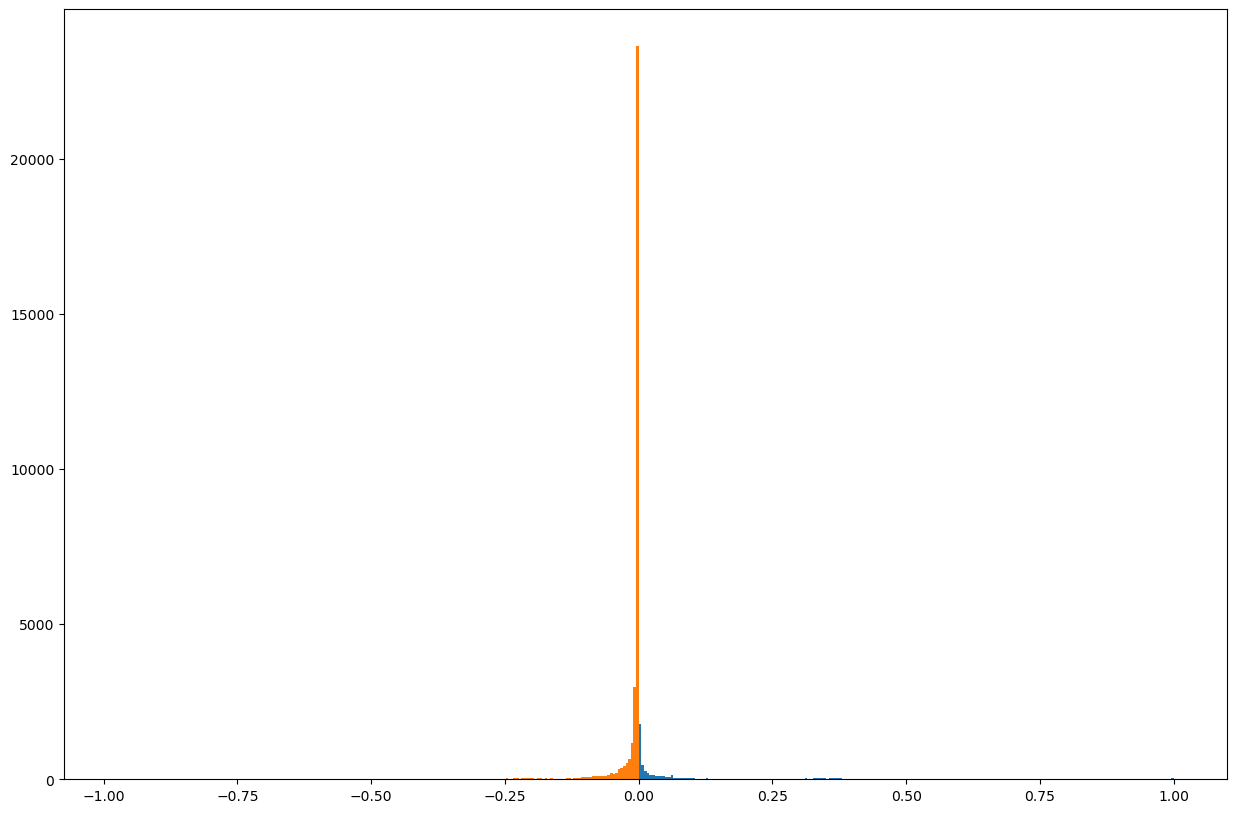

In [59]:
#plt.hist((val_y - pred_p[:,1])[idx], bins=200)
# plt.hist(val_y, bins=200)
# plt.hist(pred_p[:,1], bins=200)
plt.hist((val_y - pred_p[:,1])[idx_1], bins=200)
plt.hist((val_y - pred_p[:,1])[idx_0], bins=200)
plt.show()

In [82]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(model, out_file='tree.dot', 
                feature_names = all_df.columns,
                class_names = [0,1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

ValueError: Length of feature_names, 733 does not match number of features, 732

## LSTM Inference

In [27]:
test_df = pd.read_csv('./data/test.csv')
#test_df = pd.read_csv('./data/test.csv').iloc[uncertain_idx]
test_epitope_list, test_left_antigen_list, test_right_antigen_list, test_label_list = get_preprocessing('test', test_df)

120944it [00:05, 22968.60it/s]

test dataframe preprocessing was done.


In [28]:
test_dataset = CustomDataset(test_epitope_list, test_left_antigen_list, test_right_antigen_list, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [29]:
#model = BaseModel()
model = CNNModel()
best_checkpoint = torch.load('./best_model.pth')
model.load_state_dict(best_checkpoint)
model.eval()
model.to(device)

CNNModel(
  (epitope_embed): Embedding(27, 10, padding_idx=26)
  (left_antigen_embed): Embedding(27, 10, padding_idx=26)
  (right_antigen_embed): Embedding(27, 10, padding_idx=26)
  (epitope_cnn1): Conv1d(10, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (epitope_cnn2): Conv1d(20, 40, kernel_size=(3,), stride=(2,), padding=(1,))
  (epitope_cnn3): Conv1d(40, 10, kernel_size=(3,), stride=(2,), padding=(1,))
  (relu): ReLU(inplace=True)
  (classifier): Sequential(
    (0): LeakyReLU(negative_slope=True)
    (1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=320, out_features=80, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=80, out_features=2, bias=True)
  )
)

In [30]:
def inference(model, test_loader, device, th=CFG['THRESHOLD']):
    model.eval()
    pred_proba_label = []
    with torch.no_grad():
        for epitope_seq, left_antigen_seq, right_antigen_seq in tqdm(iter(test_loader)):
            epitope_seq = epitope_seq.to(device)
            left_antigen_seq = left_antigen_seq.to(device)
            right_antigen_seq = right_antigen_seq.to(device)
            
            model_pred = model(epitope_seq, left_antigen_seq, right_antigen_seq)
            model_pred = torch.softmax(model_pred, dim=1)[:,1].to('cpu')
            
            pred_proba_label += model_pred.tolist()
    
    pred_label = np.where(np.array(pred_proba_label)>th, 1, 0)
    return pred_label

In [35]:
preds = inference(model, test_loader, device, th=0.55)

100%|██████████| 237/237 [00:02<00:00, 84.21it/s] 


In [36]:
preds

array([0, 0, 0, ..., 0, 0, 0])

## Submission

In [37]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['label'] = preds
# submit = pd.read_csv('./submit.csv')
# submit['label'].iloc[uncertain_idx] = preds

In [38]:
submit.to_csv('./submit.csv', index=False)
print('Done.')

Done.
